In [113]:
import os
import SimpleITK as sitk
import matplotlib.pyplot as plt
%matplotlib inline

%run update_path_to_download_script
from downloaddata import fetch_data as fdata

from downloaddata import fetch_data_all
import numpy as np
inputDir = 'train/Amsterdam/101'
outputDir = 'output'

ERROR:root:File `'update_path_to_download_script.py'` not found.


# Load the image 
Binary threshold between 800 - 100000

In [114]:
# Load the image
flairImage = sitk.ReadImage(os.path.join(inputDir, 'orig', 'FLAIR.nii.gz'))
# Binary threshold between 800 - 100000
resultImage = sitk.BinaryThreshold(flairImage, lowerThreshold=800, upperThreshold=100000)
sitk.WriteImage(resultImage, os.path.join(outputDir, 'result.nii.gz'))

In [115]:
imgT1Original = sitk.ReadImage(os.path.join(inputDir, 'orig', 'FLAIR.nii.gz'))
imgT2Original = sitk.ReadImage(os.path.join(inputDir, 'orig', 'T1.nii.gz'))

In [116]:
sitk.Show(sitk.Tile(imgT1Original[:, :, 30],
                         imgT2Original[:, :, 30],
                         (2, 1, 0)))

In [146]:
imgT1Smooth = sitk.CurvatureFlow(image1=imgT1Original,
                                      timeStep=0.125,
                                      numberOfIterations=5)

imgT2Smooth = sitk.CurvatureFlow(image1=imgT2Original,
                                      timeStep=0.125,
                                      numberOfIterations=5)

sitk.Show(sitk.Tile(imgT1Smooth[:, :, 30], 
                         imgT2Smooth[:, :, 30], 
                         (2, 1, 0)))

In [118]:
print(flairImage)

Image (0x7fa966bf6b50)
  RTTI typeinfo:   itk::Image<unsigned short, 3u>
  Reference Count: 1
  Modified Time: 152682
  Debug: Off
  Object Name: 
  Observers: 
    none
  Source: (none)
  Source output name: (none)
  Release Data: Off
  Data Released: False
  Global Release Data: Off
  PipelineMTime: 152660
  UpdateMTime: 152681
  RealTimeStamp: 0 seconds 
  LargestPossibleRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [132, 256, 83]
  BufferedRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [132, 256, 83]
  RequestedRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [132, 256, 83]
  Spacing: [1.2, 0.9766, 3]
  Origin: [-80.0952, -169.878, -129.121]
  Direction: 
1 0 0
0 1 0
0 0 1

  IndexToPointMatrix: 
1.2 0 0
0 0.9766 0
0 0 3

  PointToIndexMatrix: 
0.833333 0 0
0 1.02396 0
0 0 0.333333

  Inverse Direction: 
1 0 0
0 1 0
0 0 1

  PixelContainer: 
    ImportImageContainer (0x7fa967201680)
      RTTI typeinfo:   itk::ImportImageContainer<unsigned long, unsigne

In [119]:
sitk.Show(flairImage)

sitk.Show(resultImage)

In [120]:
n = sitk.GetArrayFromImage(flairImage)
n.shape

(83, 256, 132)

In [121]:
def myshow(img, title=None, margin=0.05, dpi=80):
    nda = sitk.GetArrayViewFromImage(img)
    spacing = img.GetSpacing()
        
    if nda.ndim == 3:
        # fastest dim, either component or x
        c = nda.shape[-1]
        
        # the the number of components is 3 or 4 consider it an RGB image
        if not c in (3,4):
            nda = nda[nda.shape[0]//2,:,:]
    
    elif nda.ndim == 4:
        c = nda.shape[-1]
        
        if not c in (3,4):
            raise Runtime("Unable to show 3D-vector Image")
            
        # take a z-slice
        nda = nda[nda.shape[0]//2,:,:,:]
            
    ysize = nda.shape[0]
    xsize = nda.shape[1]
      
    # Make a figure big enough to accommodate an axis of xpixels by ypixels
    # as well as the ticklabels, etc...
    figsize = (1 + margin) * ysize / dpi, (1 + margin) * xsize / dpi

    fig = plt.figure(figsize=figsize, dpi=dpi)
    # Make the axis the right size...
    ax = fig.add_axes([margin, margin, 1 - 2*margin, 1 - 2*margin])
    
    extent = (0, xsize*spacing[1], ysize*spacing[0], 0)
    
    t = ax.imshow(nda,extent=extent,interpolation=None)
    
    if nda.ndim == 2:
        t.set_cmap("gray")
    
    if(title):
        plt.title(title)

(132, 256, 83)


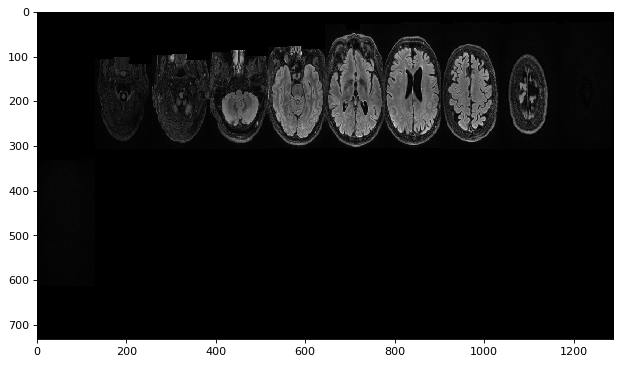

In [137]:

size = flairImage.GetSize()
print(size)
nslices = 3
slices = [ flairImage[:,:,s] for s in range(0, size[2], size[2]//10)]
myshow(sitk.Tile(slices, [10,100]))


# Preprocessing 

## 1. select slice  
### remove 1/8 from both begining and the end for all folder

In [124]:
selectimage = [ flairImage[:,:,s] for s in range(size[2]//8,size[2]-size[2]//8)]

In [138]:
len(selectimage)

63

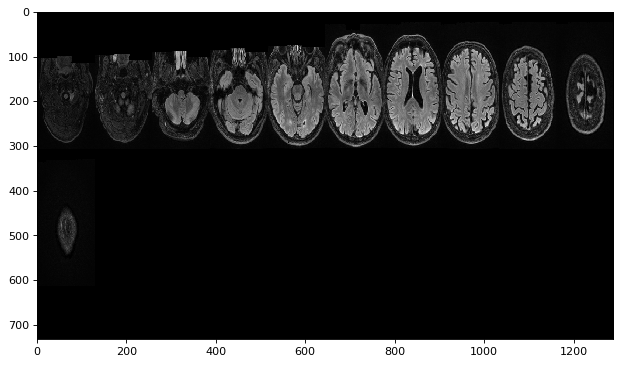

In [136]:
slices2 = [selectimage[s] for s in range(0,len(selectimage),len(selectimage)//10)]
myshow(sitk.Tile(slices2, [10,100]))


In [ ]:
only use target have something

## 2. masking the brain?

(132, 256, 83)


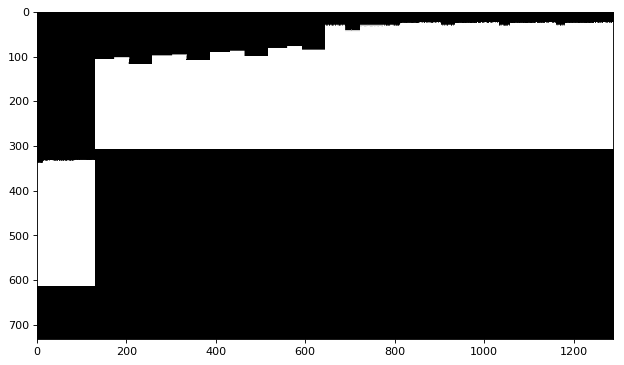

In [142]:
imgt1maskOriginal = sitk.ReadImage(os.path.join(inputDir, 'orig', 'FLAIR_mask.nii.gz'))
size = imgt1maskOriginal.GetSize()
print(size)
nslices = 3
slices = [ imgt1maskOriginal[:,:,s] for s in range(0, size[2], size[2]//10)]
myshow(sitk.Tile(slices, [10,100]))

In [157]:
imgT1Smooth30 = imgT1Smooth[:,:,30]

In [158]:
labelWhiteMatter = 1
labelGrayMatter = 2
lstSeeds = [(150,75)]

imgWhiteMatter = sitk.ConnectedThreshold(image1=imgT1Smooth30, 
                                              seedList=lstSeeds, 
                                              lower=130, 
                                              upper=190,
                                              replaceValue=labelWhiteMatter)

In [160]:
# Rescale 'imgSmooth' and cast it to an integer type to match that of 'imgWhiteMatter'
imgSmoothInt = sitk.Cast(sitk.RescaleIntensity(imgT1Smooth30), imgWhiteMatter.GetPixelID())

# Use 'LabelOverlay' to overlay 'imgSmooth' and 'imgWhiteMatter'
sitk.Show(sitk.LabelOverlay(imgSmoothInt, imgWhiteMatter))

In [161]:
imgWhiteMatterNoHoles = sitk.VotingBinaryHoleFilling(image1=imgWhiteMatter,
                                                          radius=[2]*3,
                                                          majorityThreshold=1,
                                                          backgroundValue=0,
                                                          foregroundValue=labelWhiteMatter)

sitk.Show(sitk.LabelOverlay(imgSmoothInt, imgWhiteMatterNoHoles))


In [163]:
lstSeeds = [(119, 83), (198, 80), (185, 102), (164, 43)]

imgGrayMatter = sitk.ConnectedThreshold(image1=imgT1Smooth30, 
                                             seedList=lstSeeds, 
                                             lower=150, 
                                             upper=270,
                                             replaceValue=labelGrayMatter)

imgGrayMatterNoHoles = sitk.VotingBinaryHoleFilling(image1=imgGrayMatter,
                                                         radius=[2]*3,
                                                         majorityThreshold=1,
                                                         backgroundValue=0,
                                                         foregroundValue=labelGrayMatter)

sitk.Show(sitk.LabelOverlay(imgSmoothInt, imgGrayMatterNoHoles))

In [164]:
imgLabels = imgWhiteMatterNoHoles | imgGrayMatterNoHoles

sitk.Show(sitk.LabelOverlay(imgSmoothInt, imgLabels))

In [166]:
imgMask= imgWhiteMatterNoHoles/labelWhiteMatter * imgGrayMatterNoHoles/labelGrayMatter
imgWhiteMatterNoHoles -= imgMask*labelWhiteMatter

imgLabels = imgWhiteMatterNoHoles + imgGrayMatterNoHoles

sitk.Show(sitk.LabelOverlay(imgSmoothInt, imgLabels))

RuntimeError: Exception thrown in SimpleITK Multiply: /scratch/dashboard/SimpleITK-OSX10.6-x86_64-pkg/SimpleITK-build/SimpleITK-build/Code/BasicFilters/src/sitkMultiplyImageFilter.cxx:106:
sitk::ERROR: Image2 for MultiplyImageFilter doesn't match type or dimension!

In [147]:
help(sitk.ConnectedThreshold)

Help on function ConnectedThreshold in module SimpleITK.SimpleITK:

ConnectedThreshold(*args, **kwargs)
    ConnectedThreshold(Image image1, VectorUIntList seedList, double lower=0, double upper=1, uint8_t replaceValue=1, itk::simple::ConnectedThresholdImageFilter::ConnectivityType connectivity) -> Image
    
    
    
    itk::simple::ConnectedThresholdImageFilter Functional Interface
    
    This function directly calls the execute method of ConnectedThresholdImageFilter in order to support a fully functional API



## 3. crop and pad

## 4. voxel intensity normalizarion per patient

## 5. data augmentation

In [ ]:
generater function 
